In [2]:
%matplotlib notebook
import numpy as np
from PIL import Image

import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning
from skimage.transform import downscale_local_mean #For binning
from skimage.filters import threshold_otsu, threshold_local

from statistics import median
from statistics import mode
import math 

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
#sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm   

import tiff_file 

import io 
import sys
import csv

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

In [29]:
np.set_printoptions(threshold=sys.maxsize)

def rows_n_cols(im):
    imarray = np.array(im)
    rows, cols = np.shape(imarray)
    return rows, cols


    
def floodfill_flat(array, x, y, rows, cols):
    stack = []
    if array[x,y] != 1:
        return 0
    stack.append((x,y))
    currclustersize = 1
    array[x,y] = 2
    while stack:
        xcurr, ycurr = stack.pop()
        if xcurr > 0:
            if array[xcurr-1,ycurr] == 1:
                array[xcurr-1,ycurr] = 2
                currclustersize += 1
                stack.append((xcurr-1,ycurr))
        if xcurr < rows-1:
            if array[xcurr+1,ycurr] == 1:
                array[xcurr+1,ycurr] = 2
                currclustersize += 1
                stack.append((xcurr+1,ycurr))
        if ycurr > 0:
            if array[xcurr,ycurr-1] == 1:
                array[xcurr,ycurr-1] = 2
                currclustersize += 1
                stack.append((xcurr,ycurr-1))
        if ycurr < cols-1:
            if array[xcurr,ycurr+1] == 1:
                array[xcurr,ycurr+1] = 2
                currclustersize += 1
                stack.append((xcurr,ycurr+1))
    return currclustersize

def markcluster_flat(array, x, y, rows, cols, clustersize):
    stack = []
    if array[x,y] != 2:
        return
    stack.append((x,y))
    array[x,y] = clustersize
    while stack:
        xcurr, ycurr = stack.pop()
        if xcurr > 0:
            if array[xcurr-1,ycurr] == 2:
                array[xcurr-1,ycurr] = clustersize
                stack.append((xcurr-1,ycurr))
        if xcurr < rows-1:
            if array[xcurr+1,ycurr] == 2:
                array[xcurr+1,ycurr] = clustersize
                stack.append((xcurr+1,ycurr))
        if ycurr > 0:
            if array[xcurr,ycurr-1] == 2:
                array[xcurr,ycurr-1] = clustersize
                stack.append((xcurr,ycurr-1))
        if ycurr < cols-1:
            if array[xcurr,ycurr+1] == 2:
                array[xcurr,ycurr+1] = clustersize
                stack.append((xcurr,ycurr+1))

def threshold_images(image, block_size, offset_val):
    ed_image = (image**0.2)*500
    ed_thresh = threshold_local(ed_image, block_size, offset= offset_val)
    #ed_binary_im = (ed_image > ed_thresh)
    #print(ed_binary_im[:2])
    ed_binary_im = 1*(ed_image > ed_thresh)
    #print(ed_binary_im[:2])
    #print(ed_binary_im.shape)
    return ed_binary_im

def zerolistmaker(n):
    listofzeros = ['none found'] * n
    return listofzeros

def cluster_analysis(size_lim, i, row_num, arraythresh, rows, cols):
    clusters = []
    for x in range(rows):
        #if x % 25 == 0:  #progress update
        #    print(100*x/rows)
        for y in range(cols):
            if arraythresh[x,y] == 1:
                #fill in this cluster
                clustersize = floodfill_flat(arraythresh, x, y, rows, cols)
                if clustersize >= size_lim:
                    clusters.append(clustersize)
                    #markcluster_flat(arraythresh,x,y,rows,cols,clustersize)
                    #print("clustersize= %5.3f for (x,y)= (%5.3f, %5.3f)"  %(clustersize,x,y))
                    #print(arraythresh)
                #mark finished cluster with size
                                           #max_size = (max(clusters)) * (pixel_size**2)  
    clusters.sort()
    y_mode = mode(clusters)
    count_of_ymode = clusters.count(y_mode)
    count_at_FW = count_of_ymode*0.01
    
    indexes = []
    for i in range(len(clusters)):
        val = clusters[i]
        if (clusters.count(val) > count_at_FW):
            indexes.append(val)
    FW = (abs(indexes[-1] - indexes[0]))
    
    total_num = len(clusters)
    mean_size = (sum(clusters) / len(clusters))  #pixel size squared b/c max size is an area
    median_size = (median(clusters)) 
    mode_size = (mode(clusters)) 
    
    if (i == 0) and (row_num == 1):
        print(clusters)
    
    #print("for row"+str(row_num)+", t= "+str(time_array[i]) + " hrs:")
    #print('clusters counted: %5i, mean size: %5.3f, median: %5.3f, mode: %5.3f, FW: %5.3f' %(total_num, mean_size, 
     #                                                                                  median_size, mode_size, FW))
    
    return total_num, mean_size, median_size, mode_size, FW, clusters

In [5]:
directory = "Z"
exp = "7-18-22_bkaiB_ratios"
### "data_dir" is the pathway to the folder holding the tiff files to be analyzed 
data_dir = directory+":\\Gregor L\\__Kai Colloids\\control exps\\"+exp+"\\all tiffs\\" 
#data_dir2 = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\SIA preview images\\" #bottom_row_t01\\

### "plot_saveto" is the pathway to the folder where plots and results will be saved
data_saveto= directory+":\\Gregor L\\__Kai Colloids\\control exps\\"+exp+"\\cluster analysis results\\" 

all_files = glob.glob(data_dir+"*_t*") ### this should generate an ordered list of files in "data_dir" which have "_t" in their name
print("found %i files" % len(all_files))
for i,f in enumerate(all_files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 30 files
 0 	 row1_t01_MMStack_Pos0.ome.tif
 1 	 row1_t02_MMStack_Pos0.ome.tif
 2 	 row1_t03_MMStack_Pos0.ome.tif
 3 	 row1_t04_MMStack_Pos0.ome.tif
 4 	 row1_t05_MMStack_Pos0.ome.tif
 5 	 row1_t06_MMStack_Pos0.ome.tif
 6 	 row1_t07_MMStack_Pos0.ome.tif
 7 	 row1_t08_MMStack_Pos0.ome.tif
 8 	 row1_t09_MMStack_Pos0.ome.tif
 9 	 row1_t10_MMStack_Pos0.ome.tif
 10 	 row2_t01_MMStack_Pos0.ome.tif
 11 	 row2_t02_MMStack_Pos0.ome.tif
 12 	 row2_t03_MMStack_Pos0.ome.tif
 13 	 row2_t04_MMStack_Pos0.ome.tif
 14 	 row2_t05_MMStack_Pos0.ome.tif
 15 	 row2_t06_MMStack_Pos0.ome.tif
 16 	 row2_t07_MMStack_Pos0.ome.tif
 17 	 row2_t08_MMStack_Pos0.ome.tif
 18 	 row2_t09_MMStack_Pos0.ome.tif
 19 	 row2_t10_MMStack_Pos0.ome.tif
 20 	 row3_t01_MMStack_Pos0.ome.tif
 21 	 row3_t02_MMStack_Pos0.ome.tif
 22 	 row3_t03_MMStack_Pos0.ome.tif
 23 	 row3_t04_MMStack_Pos0.ome.tif
 24 	 row3_t05_MMStack_Pos0.ome.tif
 25 	 row3_t06_MMStack_Pos0.ome.tif
 26 	 row3_t07_MMStack_Pos0.ome.tif
 27 	 row3_t08_MMStack_

In [12]:
t_num =1
one_time_all = []
for i in range(len(all_files)): 
    #print(str(all_files[i].split('\\')[-1][5:-21]))
    t = str(all_files[i].split('\\')[-1][5:-21])
    if t == ('t0'+str(t_num)) or t == ('t'+str(t_num)):
        print(all_files[i].split('\\')[-1][5:-21])
        one_time_all.append(all_files[i])
        
print(one_time_all)

t01
t01
t01
['Z:\\Gregor L\\__Kai Colloids\\control exps\\7-18-22_bkaiB_ratios\\all tiffs\\row1_t01_MMStack_Pos0.ome.tif', 'Z:\\Gregor L\\__Kai Colloids\\control exps\\7-18-22_bkaiB_ratios\\all tiffs\\row2_t01_MMStack_Pos0.ome.tif', 'Z:\\Gregor L\\__Kai Colloids\\control exps\\7-18-22_bkaiB_ratios\\all tiffs\\row3_t01_MMStack_Pos0.ome.tif']


In [14]:
frame_names = ["50% bKaiB", "35% bKaiB", "20% bKaiB", "pT (20% bKaiB)"]
### array containing the name for each frame in a tiff file to be run 
### e.g. frame 1 is an image of the "50% bKaiB" condition, frame 2 is an image of the "35% bKaiB" condition, etc.

time_array = [1, 4, 7, 9, 12, 15, 18, 21, 25, 28]
total_rows = 3
#s1 [1.1, 4.0, 7.4, 10.3, 14.7, 17.7, 20.3, 23.8, 27.0]
#s2 [1.2, 4.4, 7.8, 10.8, 15.2, 18.3, 20.8, 24.3, 28.0]
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files "bottom_row_t1", "middle_row_t1", and "top_row_t1" all correspond to t = 0.5 hrs, time_array[0]

pixel_size = 0.091 
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

eg_im= tiff_file.imread(all_files[0])
print("tiff file dimensions: "+ str(eg_im.shape))

num_times = int((len(all_files))/total_rows)
print("total number of time points: "+ str(num_times))
if num_times % 2 == 0:
    num_rows = int(num_times/2)
else:
    num_rows = int((num_times+1)/2)
print("(for image previews) number of rows = " + str(num_rows))

font_size = 16  ### font size
dpi_num = 600  ### image quality level (recommendation: 600)

tiff file dimensions: (4, 1440, 1920)
total number of time points: 10
(for image previews) number of rows = 5


# For better results, we filter & 'skeletonize' the images before analysis 
### Do we need to filter out background noise from the images? If so, we can try out different filter sizes to see which works best. The following block previews the images intended for SIA analysis, showing the filtered and skeletonized images
'skeletonize' means we find a specific threshold (based on median intensity), so all pixel values above that threshold = 1, and all pixel values below that threshold = 0. This gives structures clean borders for improved correlation analysis, g(r).

In [42]:
t_num =10

one_time_all = []
for i in range(len(all_files)): 
    #print(str(all_files[i].split('\\')[-1][5:-21]))
    t = str(all_files[i].split('\\')[-1][5:-21])
    if t == ('t0'+str(t_num)) or t == ('t'+str(t_num)):
        print(all_files[i].split('\\')[-1][5:-21])
        one_time_all.append(all_files[i])
print(one_time_all)

t10
t10
t10
['Z:\\Gregor L\\__Kai Colloids\\control exps\\7-18-22_bkaiB_ratios\\all tiffs\\row1_t10_MMStack_Pos0.ome.tif', 'Z:\\Gregor L\\__Kai Colloids\\control exps\\7-18-22_bkaiB_ratios\\all tiffs\\row2_t10_MMStack_Pos0.ome.tif', 'Z:\\Gregor L\\__Kai Colloids\\control exps\\7-18-22_bkaiB_ratios\\all tiffs\\row3_t10_MMStack_Pos0.ome.tif']


In [36]:
def show_raw_images(ax, i, frame_key):
    plt.gray()
    #date = str(one_time_all[i].split('\\')[-3][:5])
    #slide = str(one_time_all[i].split('\\')[-3][9:11])
    row = str(all_files[i].split('\\')[-1][:4])
    test_image = tiff_file.imread(all_files[i],key=[frame_key])
    t = str(all_files[i].split('\\')[-1][5:-21])
    ax.set_title(t + "; " + row, fontsize=10)
    ax.imshow(test_image) #cmap = 'gray'
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def show_threshold_images(ax, i, frame_key, block_size, offset_val):
    raw_image = tiff_file.imread(all_files[i],key=[frame_key])
    ax.set_title(" --> skeletonized", fontsize=10)
    threshold_image = threshold_images(raw_image, block_size, offset_val)
    ax.imshow(threshold_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)

t01
t01
t01
condition: 50% bKaiB


<IPython.core.display.Javascript object>


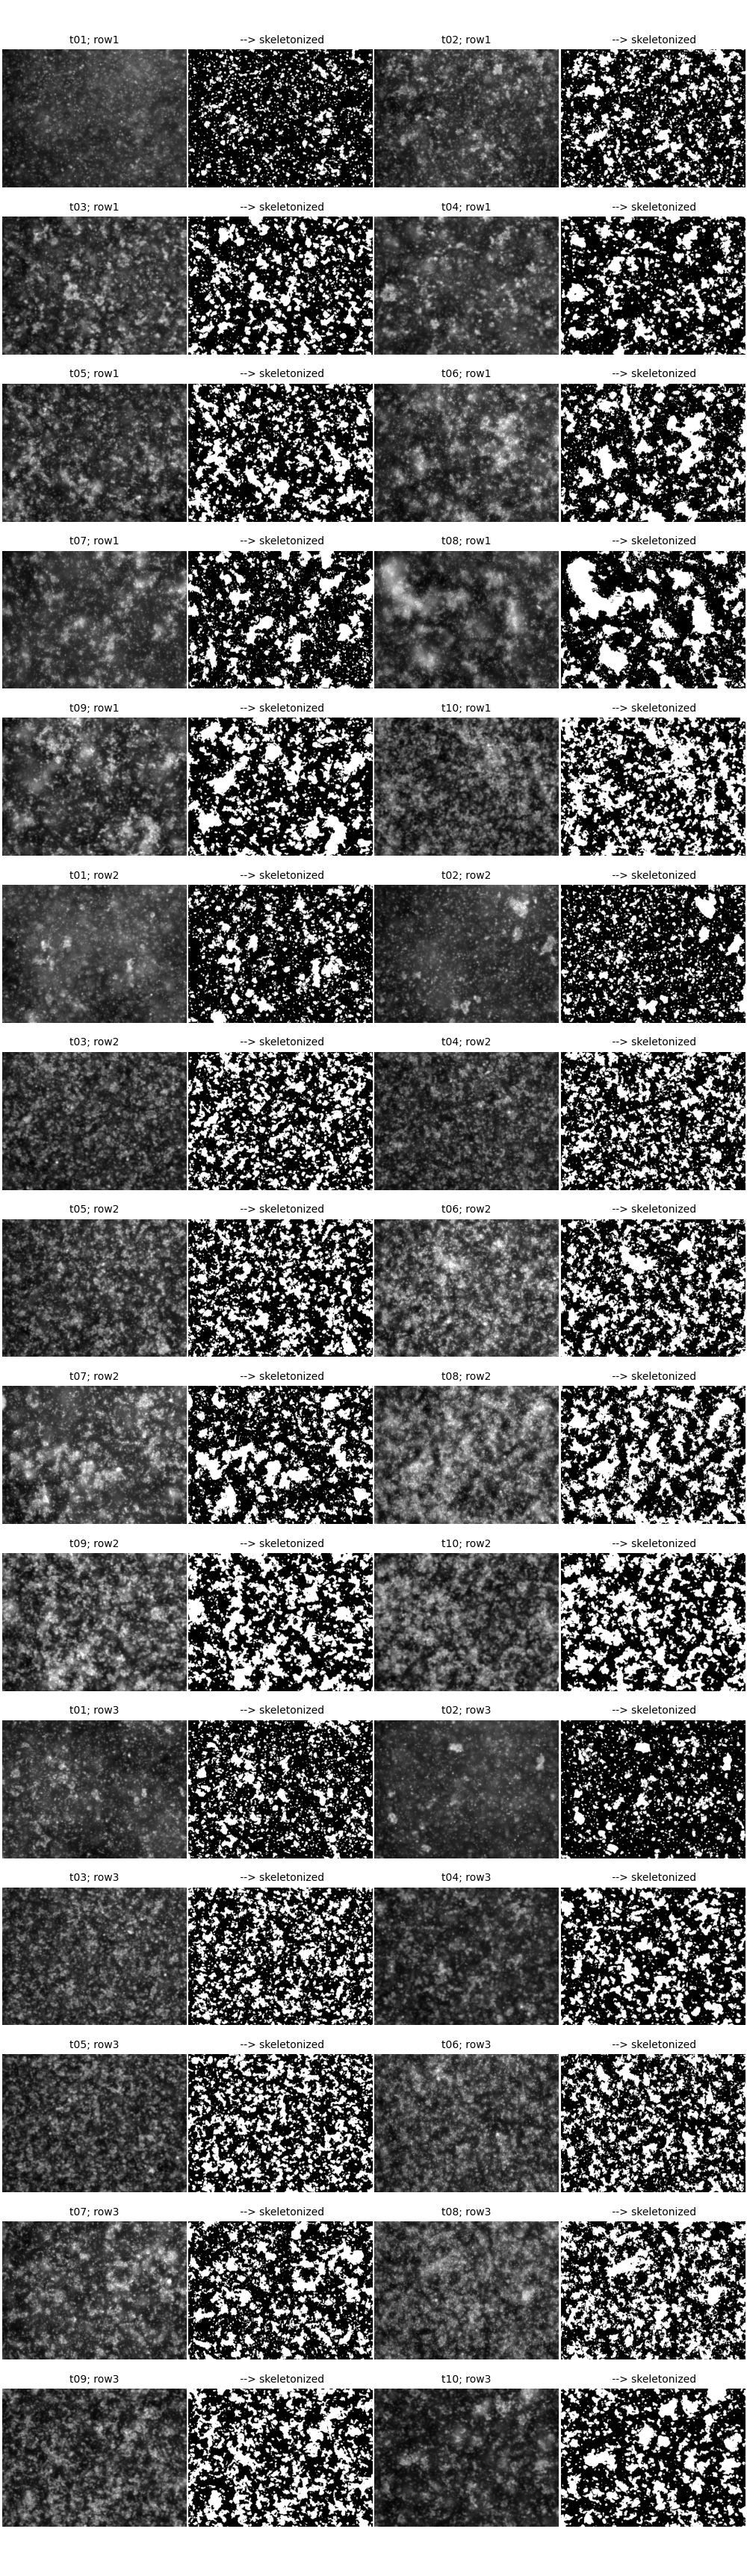

[1, 4, 7, 9, 12, 15, 18, 21, 25, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [38]:
frame_key = 0

t_num =1

one_time_all = []
for i in range(len(all_files)): 
    #print(str(all_files[i].split('\\')[-1][5:-21]))
    t = str(all_files[i].split('\\')[-1][5:-21])
    if t == ('t0'+str(t_num)) or t == ('t'+str(t_num)):
        print(all_files[i].split('\\')[-1][5:-21])
        one_time_all.append(all_files[i])

### "frame_key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed
condition = frame_names[frame_key]
time = str(time_array[t_num -1])
print("condition: "+condition)

block_size = 1051
offset_val = -20

### choose which set of tiff files should be analyzed, row1, row2 or row3
num_rows = 15
fig_height = num_rows*2.3
time_array.append(0)
i = 0
fig, axs = plt.subplots(num_rows, 4, figsize=(10,fig_height))
for j, ax in enumerate(axs.flatten()):
    if j % 2 == 0:
        show_raw_images(ax, i, frame_key)
    else:
        show_threshold_images(ax, i, frame_key, block_size, offset_val)
        i = i + 1 
plt.show()
time_array.remove(0)
print(time_array)
details = " (t= "+time+", bsize= "+str(block_size)+", offset= "+str(offset_val)+")"
### option to save this figure (uncomment below)
fig.savefig(data_saveto+"all skeletonized images for "+condition+details+".jpg", dpi=600)

In [39]:
all_nums = np.zeros((4,num_times))
all_means = np.zeros((4,num_times))
all_medians = np.zeros((4,num_times))
all_modes = np.zeros((4,num_times))
all_FWs = np.zeros((4,num_times))

nums_stdE = np.zeros((4,num_times))
means_stdE = np.zeros((4,num_times))
medians_stdE = np.zeros((4,num_times))
modes_stdE = np.zeros((4,num_times))
FWs_stdE = np.zeros((4,num_times))

In [40]:
all_cSize_at_half = np.zeros((4,num_times))

In [44]:
def select_data_arrays(t_num):
    if t_num == 1:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t1_thresh, t1_results, t1_clusters
    if t_num == 2:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t2_thresh, t2_results, t2_clusters
    if t_num == 3:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t3_thresh, t3_results, t3_clusters
    if t_num == 4:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t4_thresh, t4_results, t4_clusters
    if t_num == 5:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t5_thresh, t5_results, t5_clusters
    if t_num == 6:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t6_thresh, t6_results, t6_clusters
    if t_num == 7:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t7_thresh, t7_results, t7_clusters
    if t_num == 8:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t8_thresh, t8_results, t8_clusters
    if t_num == 9:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t9_thresh, t9_results, t9_clusters
    if t_num == 10:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t10_thresh, t10_results, t10_clusters
    
def select_cmap(frame_key):  #["50% bKaiB", "35% bKaiB", "20% bKaiB", "pT (20% bKaiB)"]
    if frame_key == 0:
        print("50% bKaiB")
        #matplotlib.cm.get_cmap('Reds')
        return 'o', 'm', bKaiB50_all_t_clusters, "50% bKaiB" #"1:3 :: KaiA:WT KaiC"
    elif frame_key == 1:
        print("35% bKaiB")
        return '<', 'hotpink', bKaiB35_all_t_clusters, "35% bKaiB" #"AE KaiC (non-binding)"
    elif frame_key == 2:
        print("20% bKaiB")
        #matplotlib.cm.get_cmap('Greens')
        return '>', 'pink', bKaiB20_all_t_clusters, "20% bKaiB"  #"EA KaiC (fixed binding)"
    elif frame_key == 3:
        print("pT (20% bKaiB)")
        #matplotlib.cm.get_cmap('Greys')
        return 's', 'k', AE_all_t_clusters, "pT (20% bKaiB)" #"AE KaiC (non-binding)"
    
def collect_results(t_number, m_or_stdE):
    thresh, results, clusters = select_data_arrays(t_number)
    total_nums = np.arange(3)
    mean_vals = np.arange(3)
    median_vals =  np.arange(3)
    mode_vals =  np.arange(3)
    FW_vals =  np.arange(3)
    for i in range(3):
        total_nums[i] = results[i][0]
        mean_vals[i] = results[i][1]
        median_vals[i] =  results[i][2]
        mode_vals[i] =  results[i][3]
        FW_vals[i] =  results[i][4]
    if m_or_stdE == 'm':
        return total_nums.mean(), mean_vals.mean(), median_vals.mean(), mode_vals.mean(), FW_vals.mean()
    if m_or_stdE == 'stdE':
        n = np.sqrt(3)
        return total_nums.std()/n, mean_vals.std()/n, median_vals.std()/n, mode_vals.std()/n, FW_vals.std()/n
    
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.2 #set the value globally
mpl.rcParams['mathtext.default'] = 'regular'

In [56]:
t1_thresh = [0.0] * 18
t2_thresh = [0.0] * 18
t3_thresh = [0.0] * 18
t4_thresh = [0.0] * 18
t5_thresh = [0.0] * 18
t6_thresh = [0.0] * 18
t7_thresh = [0.0] * 18
t8_thresh = [0.0] * 18
t9_thresh = [0.0] * 18
t10_thresh = [0.0] * 18

t1_results = [0.0] * 18
t2_results = [0.0] * 18
t3_results = [0.0] * 18
t4_results = [0.0] * 18
t5_results = [0.0] * 18
t6_results = [0.0] * 18
t7_results = [0.0] * 18
t8_results = [0.0] * 18
t9_results = [0.0] * 18
t10_results = [0.0] * 18

t1_clusters = []
t2_clusters = []
t3_clusters = []
t4_clusters = []
t5_clusters = []
t6_clusters = []
t7_clusters = []
t8_clusters = []
t9_clusters = []
t10_clusters = []

row_to_write = [''] * 11 * 5

block_size = 1051
offset_val = -20
#select_data_arrays(3)
rows, cols, = rows_n_cols(threshold_images(tiff_file.imread(all_files[0],key=[0]), block_size, offset_val))
print(rows, cols)

1440 1920


In [46]:
print(num_times)

10


In [58]:
fk = 3

for i in range(num_times):
    t_num = 1 + i

    thresh, results, clusters = select_data_arrays(t_num)
    one_time_all = []
    for i in range(len(all_files)): 
        #print(str(all_files[i].split('\\')[-1][5:-21]))
        t = str(all_files[i].split('\\')[-1][5:-21])
        if t == ('t0'+str(t_num)) or t == ('t'+str(t_num)):
            print(all_files[i].split('\\')[-1][5:-21])
            one_time_all.append(all_files[i])
    #print(thresh, results, clusters)

    condition = frame_names[fk]
    time = str(time_array[t_num -1])

    block_size = 1051
    offset_val = -20

    print("condition: "+condition + "\t time: "+time+" hrs")

    beads_per_cluster = 1
    size_lim = int( (beads_per_cluster*0.785) / (pixel_size**2) ) + 1 #add 1 to round up just for good measure (i.e. 473+2=475)     
    print("define clusters as at least: "+str(beads_per_cluster)+" beads --> size_lim = "+str(size_lim)+" pixels^2")
    
    for i in range(3):
        thresh[i] = threshold_images(tiff_file.imread(one_time_all[i],key=[fk]), block_size, offset_val)

        total_num, mean_size, median_size, mode_size, FW, clusters_list = cluster_analysis(size_lim, i, 1, thresh[i], rows, cols)


        print('clusters counted: %i, mean size: %5.3f, median: %5.3f, mode: %5.3f, FW: %5.3f' %(total_num, mean_size, 
                                                                                           median_size, mode_size, FW))
        clusters.extend(clusters_list) 

        results[i] = (total_num, mean_size, median_size, mode_size, FW)
        
for i in range(num_times):
    all_nums[fk,i],all_means[fk,i],all_medians[fk,i],all_modes[fk,i],all_FWs[fk,i] = collect_results(i+1, m_or_stdE= 'm')
    
    nums_stdE[fk,i],means_stdE[fk,i],medians_stdE[fk,i],modes_stdE[fk,i],FWs_stdE[fk,i] =collect_results(i+1, m_or_stdE= 'stdE')
    
if fk == 0:
    bKaiB50_all_t_clusters=[t1_clusters,t2_clusters,t3_clusters,t4_clusters,
                       t5_clusters,t6_clusters,t7_clusters,t8_clusters,t9_clusters]
if fk == 1:
    bKaiB35_all_t_clusters=[t1_clusters,t2_clusters,t3_clusters,t4_clusters,
                       t5_clusters,t6_clusters,t7_clusters,t8_clusters,t9_clusters]
if fk == 2:
    bKaiB20_all_t_clusters=[t1_clusters,t2_clusters,t3_clusters,t4_clusters,
                       t5_clusters,t6_clusters,t7_clusters,t8_clusters,t9_clusters]
if fk == 3:
    AE_all_t_clusters=[t1_clusters,t2_clusters,t3_clusters,t4_clusters,
                       t5_clusters,t6_clusters,t7_clusters,t8_clusters,t9_clusters]


selected arrays for t_num= 1, 1 hrs
t01
t01
t01
condition: pT (20% bKaiB)	 time: 1 hrs
define clusters as at least: 1 beads --> size_lim = 95 pixels^2
clusters counted: 1029, mean size: 473.898, median: 222.000, mode: 113.000, FW: 11219.000
clusters counted: 1028, mean size: 526.576, median: 242.000, mode: 104.000, FW: 11890.000
clusters counted: 1014, mean size: 596.889, median: 282.000, mode: 98.000, FW: 9388.000
selected arrays for t_num= 2, 4 hrs
t02
t02
t02
condition: pT (20% bKaiB)	 time: 4 hrs
define clusters as at least: 1 beads --> size_lim = 95 pixels^2
clusters counted: 1045, mean size: 612.885, median: 308.000, mode: 111.000, FW: 8014.000
clusters counted: 1120, mean size: 523.941, median: 264.000, mode: 97.000, FW: 9771.000
clusters counted: 1023, mean size: 520.324, median: 271.000, mode: 112.000, FW: 10684.000
selected arrays for t_num= 3, 7 hrs
t03
t03
t03
condition: pT (20% bKaiB)	 time: 7 hrs
define clusters as at least: 1 beads --> size_lim = 95 pixels^2
clusters cou

In [ ]:
'''AE_all_t_clusters=[t1_clusters,t2_clusters,t3_clusters,t4_clusters,
                       t5_clusters,t6_clusters,t7_clusters,t8_clusters,t9_clusters]'''
#all_nums[fk,i],all_means[fk,i],all_medians[fk,i],all_modes[fk,i],all_FWs[fk,i]
#nums_stdE[fk,i],means_stdE[fk,i],medians_stdE[fk,i],modes_stdE[fk,i],FWs_stdE[fk,i]

In [61]:
all_clusters_cntrl_dict = {}
all_clusters_cntrl_dict["bKaiB50_all_t_clusters"] = bKaiB50_all_t_clusters
all_clusters_cntrl_dict["bKaiB35_all_t_clusters"] = bKaiB35_all_t_clusters
all_clusters_cntrl_dict["bKaiB20_all_t_clusters"] = bKaiB20_all_t_clusters
all_clusters_cntrl_dict["AE_all_t_clusters"] = AE_all_t_clusters

all_clusters_cntrl_dict["all_nums"] = all_nums
all_clusters_cntrl_dict["nums_stdE"] = nums_stdE

all_clusters_cntrl_dict["all_means"] = all_means
all_clusters_cntrl_dict["means_stdE"] = means_stdE

all_clusters_cntrl_dict["all_medians"] = all_medians
all_clusters_cntrl_dict["medians_stdE"] = medians_stdE

all_clusters_cntrl_dict["all_modes"] = all_modes
all_clusters_cntrl_dict["modes_stdE"] = modes_stdE

all_clusters_cntrl_dict["all_FWs"] = all_FWs
all_clusters_cntrl_dict["FWs_stdE"] = FWs_stdE

In [62]:
dic_saveto = directory+":\\Gregor L\\__Kai Colloids\\cluster analysis\\fresh results\\" 
svg_saveto = data_saveto #directory+":\\Gregor L\\__Kai Colloids\\cluster analysis\\svg files\\" 


In [64]:
file_title = "all_clusters_cntrl_dict"
with open(file_title+".pkl", 'wb') as f:
    pickle.dump(all_clusters_cntrl_dict, f)

In [ ]:
file_title = "all_clusters_cntrl_dict"
#all_clusters_dict (clusters AL 1 beads, bsize= 1051, offset= -20)
with open(file_title+".pkl", "rb" ) as f:
    all_clusters_dict = pickle.load(f)

WTkA_all_t_clusters = all_clusters_dict["WTkA_all_t_clusters"]
EA_all_t_clusters = all_clusters_dict["EA_all_t_clusters"]
AE_all_t_clusters = all_clusters_dict["AE_all_t_clusters"]

all_nums = all_clusters_dict["all_nums"] 
nums_stdE = all_clusters_dict["nums_stdE"]  

all_means = all_clusters_dict["all_means"]  
means_stdE = all_clusters_dict["means_stdE"]  

all_medians = all_clusters_dict["all_medians"]  
medians_stdE = all_clusters_dict["medians_stdE"]  

all_modes = all_clusters_dict["all_modes"]  
modes_stdE = all_clusters_dict["modes_stdE"]  

all_FWs = all_clusters_dict["all_FWs"]  
FWs_stdE = all_clusters_dict["FWs_stdE"]  

print(len(WTkA_all_t_clusters[8]))
print(len(EA_all_t_clusters[8]))
print(len(AE_all_t_clusters[8]))
print(all_FWs)

In [ ]:
results_dict = {}
file_title = "all_SIA_dict"
with open(file_title+".pkl", 'rb') as f:
    results_dict = pickle.load(f)

In [ ]:
WTkA_all_t_A_vals = results_dict["WTkA"]["all_A_vals"]  
WTkA_all_t_cl_vals = results_dict["WTkA"]["all_cl_vals"]  

EA_all_t_A_vals = results_dict["EA"]["all_A_vals"]  
EA_all_t_cl_vals = results_dict["EA"]["all_cl_vals"]  

AE_all_t_A_vals = results_dict["AE"]["all_A_vals"]  
AE_all_t_cl_vals = results_dict["AE"]["all_cl_vals"]  

all_avg_gr = results_dict["avg_gr"]  
all_gr_stdE = results_dict["gr_stdE"]  

all_avg_fits = results_dict["avg_fits"]  
all_fits_stdE = results_dict["fits_stdE"]  

all_avg_A = results_dict["avg_A"]  
all_A_stdE = results_dict["A_stdE"]  

all_avg_cl = results_dict["avg_cl"]  
all_cl_stdE = results_dict["cl_stdE"]  

In [65]:
all_true_times = np.array([[0.7, 3.7, 6.7, 10.0, 12.8, 17.7, 21.7, 24.9, 28.2],
                           [1.0, 3.8, 6.8, 10.2, 13.1, 18.0, 21.9, 25.3, 28.7],
                           [1.1, 4.0, 7.4, 10.3, 14.7, 17.7, 20.3, 23.8, 27.0],
                           [1.2, 4.4, 7.8, 10.8, 15.2, 18.3, 20.8, 24.3, 28.0]])
#all_true_times?
all_true_times.mean(axis=0)
time_stdE = (all_true_times.std(axis=0))/np.sqrt(4)

<IPython.core.display.Javascript object>


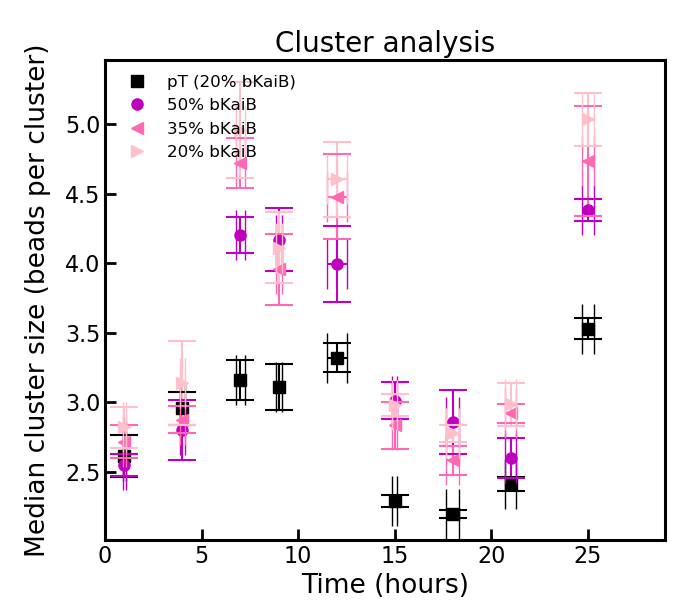

pT (20% bKaiB)
50% bKaiB
35% bKaiB
20% bKaiB


In [76]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)

end_index = 9
y_array = all_medians  #all_nums[fk,i], all_means[fk,i], all_medians[fk,i], all_modes[fk,i], all_FWs[fk,i]
y_stdE = medians_stdE   #nums_stdE[fk,i],means_stdE[fk,i],medians_stdE[fk,i],modes_stdE[fk,i],FWs_stdE[fk,i]
s_time_array = time_array[:end_index]

this_plot = 'Median cluster size (beads per cluster)'  
#'Mean cluster size ($\mu$m$^{{2}}$)'  #'Clusters found (number)' #'FW at 1% max (beads per cluster)'
this_plot_s = "bKaiB control "+this_plot

title = "Cluster analysis" 
ax.set_title(title, fontsize= (font_size))

#ax.invert_yaxis()
ax.set_ylabel(this_plot, fontsize=font_size-1, labelpad= 10)
#ax.tick_params(axis='y', direction='in', which='major', length=8, width=2, labelsize=font_size-6)
#ax.set_ylim(0, 800)
#ax.set_ylim(50, 2000)
#ax.set_yscale("log")
#ax.set_ylim(1.03, 1.95)
#ax.set_ylim(999, 201)

ax.set_xlabel('Time (hours)', fontsize=font_size-1)
ax.set_xlim(0, 29)

markerSize = 8
markerSize2 = 8
elinew = 1.5
xelinew = 1

px_per_b = 95

###########################################################################
###########################################################################
fk = 3
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
#marker = '--'+marker
ax.plot(s_time_array, (y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
            capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, xerr = time_stdE, fmt = 'none', 
            capthick=xelinew, ecolor=cmap, capsize=18)

fk = 0
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
#marker = '--'+marker
ax.plot(s_time_array,(y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
            capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, xerr = time_stdE, fmt = 'none', 
            capthick=xelinew, ecolor=cmap, capsize=18)

fk = 1
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
#marker = '--'+marker
ax.plot(s_time_array, (y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
            capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, xerr = time_stdE, fmt = 'none', 
            capthick=xelinew, ecolor=cmap, capsize=18)

fk = 2
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
#marker = '--'+marker
ax.plot(s_time_array, (y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
            capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, xerr = time_stdE, fmt = 'none', 
            capthick=xelinew, ecolor=cmap, capsize=18)
###########################################################################
###########################################################################

plt.subplots_adjust(bottom=0.1, left=0.15, right=0.95, top=0.9)
ax.legend(fontsize=font_size-8, loc='upper left', framealpha= 0, frameon=False)
#ax2.legend(fontsize=font_size-4, framealpha= 0, frameon=False)
plt.show()

#threshold_details = " (clusters AL "+str(beads_per_cluster)+" beads, bsize= "+str(block_size)+", offset= "+str(offset_val)+")"
fig.savefig(data_saveto+this_plot_s+".jpg", dpi=600, transparent=True)
fig.savefig(svg_saveto+this_plot_s+".svg", dpi=800, transparent=True)

In [ ]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)
ax2 = ax.twinx()
ax2.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax2.tick_params(axis='both', direction='in', which='minor', length=8, width=2, labelsize=font_size-4)


this_plot = 'Beads per cluster'  
#'mean cluster size ($\mu$m$^{{2}}$)'  #'clusters found (number)' #'FW at 1% max ($\mu$m$^{{2}}$)'
this_plot_s = "(FP overlay) pT, pS "+this_plot

title = "SIA & Cluster analysis" 
ax.set_title(title, fontsize= (font_size))

#ax.set_ylabel(this_plot, fontsize=font_size-1, labelpad= 12)
#ax.tick_params(axis='y', direction='in', which='major', length=8, width=2, labelsize=font_size-6)
#ax.set_ylim(1.5, 6.4)
#ax.set_yscale("log")

#ax2.yaxis.set_rotate_label(False)  # disable automatic rotation
ax2.set_ylabel('FP', rotation = -90, fontsize=font_size-1, labelpad= 20) #, labelpad= 0, ha='center', va='center'
ax2.set_ylim(201, 345)

ax.set_xlabel('Time (hours)', fontsize=font_size-1)
ax.set_xlim(0, 29)

markerSize = 8
markerSize2 = 8
elinew = 1.5

px_per_b = 95

###########################################################################
###########################################################################
end_index = 9
y_array = all_avg_cl  #all_avg_A[fk,i], all_avg_cl[fk,i]
y_stdE = all_cl_stdE   #all_A_stdE[fk,i], all_cl_stdE[fk,i]
s_time_array = time_array

###########################################################################
fk = 2
marker, cmap, cmap2, data_label = select_cmap(fk)
#marker = '--'+marker
new_yarray = y_array[fk]*2 #(((y_array[fk]*2)**2)*np.pi)/px_per_b 
new_ystdE = y_stdE[fk]*2 #(((y_stdE[fk]*2)**2)*np.pi)/px_per_b 
ax.plot(s_time_array, new_yarray,marker, ms=markerSize, c=cmap, mfc='w' )#, label = data_label)
ax.errorbar(s_time_array, new_yarray, yerr =new_ystdE, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
ax2.plot(FP_time, FP_EA_avg, marker, ms=markerSize2, c=cmap, alpha = 0.2, label = "FP "+data_label)

fk = 3
marker, cmap, cmap2, data_label = select_cmap(fk)
#marker = '--'+marker
new_yarray = y_array[fk]*2 #(((y_array[fk]*2)**2)*np.pi)/px_per_b 
new_ystdE = y_stdE[fk]*2 #(((y_stdE[fk]*2)**2)*np.pi)/px_per_b 
ax.plot(s_time_array, new_yarray, marker, ms=markerSize, c=cmap, mfc='w')#, label = data_label)
ax.errorbar(s_time_array,new_yarray, yerr = new_ystdE, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
ax2.plot(FP_time, FP_AE_avg, marker, ms=markerSize2, c=cmap, alpha = 0.2, label = "FP "+data_label)
###########################################################################
###########################################################################
###########################################################################

end_index = 9
y_array = all_medians  #all_nums[fk,i], all_means[fk,i], all_medians[fk,i], all_modes[fk,i], all_FWs[fk,i]
y_stdE = medians_stdE   #nums_stdE[fk,i],means_stdE[fk,i],medians_stdE[fk,i],modes_stdE[fk,i],FWs_stdE[fk,i]
s_time_array = time_array[:end_index]

###########################################################################
fk = 2
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
#marker = '--'+marker
ax.plot(s_time_array, (y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
            capthick=elinew, ecolor=cmap, capsize=10)

fk = 3
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
#marker = '--'+marker
ax.plot(s_time_array, (y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
            capthick=elinew, ecolor=cmap, capsize=10)
###########################################################################
###########################################################################

plt.subplots_adjust(bottom=0.1, left=0.15, right=0.85, top=0.9)
ax.legend(fontsize=font_size-4, framealpha= 0, frameon=False)
#ax2.legend(fontsize=font_size-4, framealpha= 0, frameon=False)
plt.show()

#fig.savefig(data_saveto+this_plot_s+".jpg", dpi=800)
#fig.savefig(svg_saveto+this_plot_s+".svg", dpi=800)

In [ ]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)

ax.set_xscale("log")

markerSize = 2
linew = 2.5
alpha_num = 0.99

fk = 0
#### up to 28 hrs
#WT=> 'RdPu' cmap2(0.995-(i*0.124)), alpha=0.9)   cmap, alpha=(0.45-(i*0.04))
#EA=> 'Blues'  cmap2(0.99-(i*0.124)), alpha=0.99)    cmap, alpha=(0.35-(i*0.03))
#AE=> cmap= 'spring'  cmap2= 'gist_yarg'   cmap2(0.99-(i*0.120)), alpha=0.7)   cmap(0.99), alpha=(0.05+(i*0.08))
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
marker = '-'
cmap2 = matplotlib.cm.get_cmap('Purples')   
#cmap = matplotlib.cm.get_cmap('spring')(0.95)
lines1 = []                                
lines2 = []
time_arr = []
for i in range(0,9,2):
    time = str(time_array[i])+" hrs"
    time_arr.append(time)
    x_data = np.array(sorted(all_t_clusters[i])) /95
    N = len(x_data)
    y_data = (np.linspace(1,N,N))/N
    
    lines1 += ax.plot(x_data, y_data,marker, linewidth=linew, c=cmap, alpha=(0.5-((i-4)*0.08)))
    lines2 += ax.plot(x_data, y_data,marker, linewidth=linew, c=cmap2(0.999-(i*0.12)), alpha=(0.98-((i-0)*0.08)))
     #label = time) 
    
    #AE:
    '''lines1 += ax.plot(x_data, y_data,marker, linewidth=linew, c=cmap2(0.99-(i*0.12)), alpha=(0.979-((i-1)*0.02)))
    lines2 += ax.plot(x_data, y_data,marker, linewidth=linew, c=cmap, alpha=(0.08+((i-1)*0.07)), label = time)'''
    
    
    #cSize_at_half = np.interp(0.5, y_data,x_data)
    print(0.99-(i*0.242))
    #all_cSize_at_half[fk][i] = cSize_at_half
    

print(all_cSize_at_half)
#ax.set_xlim(90, 2e4)
ax.set_xlim(0.9, 130)
ax.set_ylim(0, 1.02)
    
title =  data_label #+ " (normalized CDF)"   #"Time = " + str(time) + " hrs,
ax.set_title(title, fontsize= (font_size))
plt.ylabel('Normalized count', fontsize=font_size-1)
plt.xlabel('Sorted cluster sizes (beads per cluster)', fontsize=font_size-1)


#leg1 = ax.legend(markerscale=5., fontsize=font_size-6, loc = 'lower right', framealpha= 0, frameon=False)
from matplotlib.legend import Legend
leg1 = Legend(ax, lines1, time_arr, markerscale=2., fontsize=font_size-6,
             loc='lower right', framealpha= 0, frameon=False)
ax.add_artist(leg1);
leg2 = Legend(ax, lines2, time_arr, markerscale=2., fontsize=font_size-6,
             loc='lower right', framealpha= 0, frameon=False)
ax.add_artist(leg2);


# change the line width for the legend
for line in leg1.get_lines():
    line.set_linewidth(5.0)
    
for line in leg2.get_lines():
    line.set_linewidth(5.0)

plt.show()
if data_label == "1:3 :: KaiA:WT KaiC":
    data_label = "WT + KaiA"
title =  data_label + " (normalized CDF)"
fig.savefig(data_saveto+ "logx rep hrs "+title+".png", dpi=800, bbox_inches ='tight')
fig.savefig(svg_saveto+ "logx rep hrs "+title+".svg", dpi=800, bbox_inches ='tight')

In [ ]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)

ax.set_xscale("log")
marker = '-'
markerSize = 2
linew = 2.5
alpha_num = 0.99

fk = 2
#WT=> 'RdPu'  cmap2(0.99-(i*0.242)), alpha=0.85)   cmap, alpha=(0.2-(i*0.03))
#EA=> 'Blues'  c=cmap2(0.99-(i*0.24)), alpha=0.95)    cmap, alpha=(0.25-(i*0.03))
#AE=> cmap= 'spring'  cmap2= 'gist_yarg'   cmap2(0.99-(i*0.238)), alpha=0.7   cmap(0.99), alpha=(0.05+(i*0.1))
cmap, all_t_clusters, data_label = select_cmap(fk)
cmap2 = matplotlib.cm.get_cmap('Blues')   
#cmap = matplotlib.cm.get_cmap('spring')
lines1 = []                                
lines2 = []
time_arr = []
for i in range(5):
    time = str(time_array[i])+" hrs"
    time_arr.append(time)
    x_data = np.array(sorted(all_t_clusters[i])) /95
    N = len(x_data)
    y_data = (np.linspace(1,N,N))/N
    lines1 += ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap2(0.99-(i*0.24)), alpha=0.95)
    lines2 += ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap, alpha=(0.25-(i*0.03)), label = time)
    cSize_at_half = np.interp(0.5, y_data,x_data)
    print(0.99-(i*0.242))
    all_cSize_at_half[fk][i] = cSize_at_half
    

print(all_cSize_at_half)
#ax.set_xlim(90, 2e4)
ax.set_xlim(0.9, 130)
ax.set_ylim(0, 1.02)
    
title =  data_label #+ " (normalized CDF)"   #"Time = " + str(time) + " hrs,
ax.set_title(title, fontsize= (font_size))
plt.ylabel('Normalized count', fontsize=font_size-1)
plt.xlabel('Sorted cluster sizes (beads per cluster)', fontsize=font_size-1)


leg1 = ax.legend(markerscale=5., fontsize=font_size-4, loc = 'lower right', framealpha= 0, frameon=False)
from matplotlib.legend import Legend
leg2 = Legend(ax, lines1, time_arr, markerscale=2., fontsize=font_size-4,
             loc='lower right', framealpha= 0, frameon=False)
ax.add_artist(leg2);


# change the line width for the legend
for line in leg1.get_lines():
    line.set_linewidth(5.0)
    
for line in leg2.get_lines():
    line.set_linewidth(5.0)

plt.show()
if data_label == "1:3 :: KaiA:WT KaiC":
    data_label = "WT + KaiA"
title =  data_label + " (normalized CDF)"
#fig.savefig(data_saveto+ "logx "+title+".png", dpi=800, bbox_inches ='tight')
#fig.savefig(svg_saveto+ "logx "+title+".svg", dpi=800, bbox_inches ='tight')

In [ ]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)

#ax.set_yscale("log")
ax.set_xscale("log")
marker = '-'
markerSize = 2
linew = 4
alpha_num = 0.5

time_key = 6

fk = 3 
cmap, all_t_clusters, data_label = select_cmap(fk)
x_data = np.array(sorted(all_t_clusters[time_key])) /95
N = len(x_data)
y_data = (np.linspace(1,N,N))/N
ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap, alpha=alpha_num, label = data_label)

fk = 2 
cmap, all_t_clusters, data_label = select_cmap(fk)
x_data = np.array(sorted(all_t_clusters[time_key])) /95
N = len(x_data)
y_data = (np.linspace(1,N,N))/N
ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap, alpha=alpha_num, label = data_label)

fk = 0
cmap, all_t_clusters, data_label = select_cmap(fk)
x_data = np.array(sorted(all_t_clusters[time_key])) /95
N = len(x_data)
y_data = (np.linspace(1,N,N))/N
ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap, alpha=alpha_num, label = data_label)

#ax.set_xlim(80, 2.5*10e4)
ax.set_xlim(0.9, 130)

ax.set_ylim(0, 1.02)

time = "Time = "+str(time_array[time_key])+" hours"
title =  time + ", normalized CDF"  #"Time = " + str(time) + " hrs,
ax.set_title(title, fontsize= (font_size))
plt.ylabel('Normalized count', fontsize=font_size-1)
plt.xlabel('Sorted cluster sizes (beads per cluster)', fontsize=font_size-1)
leg1 = ax.legend(markerscale=5., fontsize=font_size-4, loc = 'lower right', framealpha= 0, frameon=False)

for line in leg1.get_lines():
    line.set_linewidth(5.0)  
plt.show()

#fig.savefig(data_saveto+ "logy AE, EA, WTkA - "+title+".png", dpi=800, bbox_inches ='tight')
#fig.savefig(svg_saveto+ "logy AE, EA, WTkA - "+title+".svg", dpi=800, bbox_inches ='tight')

In [ ]:
import csv

FP_time = []
FP_WTkA_r1 = []
FP_WTkA_r2 = []
FP_EA_r1 = []
FP_EA_r2 = []
FP_AE_r1 = []
FP_AE_r2 = []

FP_EA_avg = []
FP_AE_avg = []
with open("formatted Michelle's FP data.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        #print(row[0], row[1], row[2], row[5], row[6], row[7], row[8])
        FP_time.append(row[0])
        FP_WTkA_r1.append(row[1])
        FP_WTkA_r2.append(row[2])
        FP_EA_r1.append(row[5])
        FP_EA_r2.append(row[6])
        FP_AE_r1.append(row[7])
        FP_AE_r2.append(row[8])
        EA_avg = (row[5] + row[6])/2
        AE_avg = (row[7] + row[8])/2
        FP_EA_avg.append(EA_avg)
        FP_AE_avg.append(AE_avg)

In [ ]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)
ax2 = ax.twinx()
ax2.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax2.tick_params(axis='both', direction='in', which='minor', length=8, width=2, labelsize=font_size-4)

end_index = 9
y_array = all_FWs  #all_nums[fk,i], all_means[fk,i], all_medians[fk,i], all_modes[fk,i], all_FWs[fk,i]
y_stdE = FWs_stdE   #nums_stdE[fk,i],means_stdE[fk,i],medians_stdE[fk,i],modes_stdE[fk,i],FWs_stdE[fk,i]
s_time_array = time_array[:end_index]

this_plot = 'FW at 1% max (beads per cluster)'  
#'mean cluster size ($\mu$m$^{{2}}$)'  #'clusters found (number)' #'FW at 1% max ($\mu$m$^{{2}}$)'
this_plot_s = "0-28_"+this_plot

title = "Cluster analysis" 
ax.set_title(title, fontsize= (font_size))

ax.set_ylabel(this_plot, fontsize=font_size-1, labelpad= 15)
ax.tick_params(axis='y', direction='in', which='major', length=8, width=2, labelsize=font_size-6)
ax.set_ylim(-20, 800)
#ax.set_yscale("log")

#ax2.yaxis.set_rotate_label(False)  # disable automatic rotation
ax2.set_ylabel('FP', rotation = -90, fontsize=font_size-1, labelpad= 20) #, labelpad= 0, ha='center', va='center'
ax2.set_ylim(201, 325)

ax.set_xlabel('Time (hours)', fontsize=font_size-1)
ax.set_xlim(0, 29)

markerSize = 8
markerSize2 = 5
elinew = 1.5

px_per_b = 95

###########################################################################
###########################################################################
fk = 0
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array,(y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
            capthick=elinew, ecolor=cmap, capsize=10)
ax2.plot(FP_time, FP_WTkA_r1, marker, ms=markerSize2, c=cmap, alpha = 0.2, label = "FP "+data_label)
ax2.plot(FP_time, FP_WTkA_r2, marker, ms=markerSize2, c=cmap, alpha = 0.2)

fk = 2
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array, (y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
            capthick=elinew, ecolor=cmap, capsize=10)
ax2.plot(FP_time, FP_EA_r1, marker, ms=markerSize2, c=cmap, alpha = 0.2, label = "FP "+data_label)
ax2.plot(FP_time, FP_EA_r2, marker, ms=markerSize2, c=cmap, alpha = 0.2)

fk = 3
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array, (y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
            capthick=elinew, ecolor=cmap, capsize=10)
ax2.plot(FP_time, FP_AE_r1, marker, ms=markerSize2, c=cmap, alpha = 0.2, label = "FP "+data_label)
ax2.plot(FP_time, FP_AE_r2, marker, ms=markerSize2, c=cmap, alpha = 0.2)
###########################################################################
###########################################################################

plt.subplots_adjust(bottom=0.1, left=0.15, right=0.85, top=0.9)
ax.legend(fontsize=font_size-4, loc='upper left', framealpha= 0, frameon=False)
#ax2.legend(fontsize=font_size-4, framealpha= 0, frameon=False)
plt.show()

#threshold_details = " (clusters AL "+str(beads_per_cluster)+" beads, bsize= "+str(block_size)+", offset= "+str(offset_val)+")"
fig.savefig(data_saveto+"(FP overlay) "+this_plot_s+".jpg", dpi=600)
fig.savefig(svg_saveto+"(FP overlay) "+this_plot_s+".svg", dpi=800)

In [ ]:
%matplotlib notebook
font_size = 18
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=6, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=3, width=2, labelsize=font_size-4)

this_plot = 'Clusters Found (number)'  
#'mean cluster size ($\mu$m$^{{2}}$)'  #'clusters found (number)' #'FW at 10% max ($\mu$m$^{{2}}$)'
this_plot_s = "0-28_"+this_plot
px_per_b = 1 #95

end_index = 9
y_array = all_means  #all_nums[fk,i], all_means[fk,i], all_medians[fk,i], all_modes[fk,i], all_FWs[fk,i]
y_stdE = means_stdE   #nums_stdE[fk,i],means_stdE[fk,i],medians_stdE[fk,i],modes_stdE[fk,i],FWs_stdE[fk,i]
s_time_array = time_array[:end_index]

#ax.set_ylim(2, 21)
ax.set_xlim(0, 29)
marker = '--d'
markerSize = 8
elinew = 1.5
#threshold_details = " (clusters >= "+str(beads_per_cluster)+" beads)"
title = "Cluster analysis" 

ax.set_title(title, fontsize= (font_size))
plt.ylabel(this_plot, fontsize=font_size)
plt.xlabel('Time (hours)', fontsize=font_size)

fk = 0
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array,(y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
            capthick=elinew, ecolor=cmap, capsize=10)
fk = 2
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array, (y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
            capthick=elinew, ecolor=cmap, capsize=10)
fk = 3
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array, (y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
            capthick=elinew, ecolor=cmap, capsize=10)

plt.show()
ax.legend(fontsize=font_size-2, framealpha= 0, frameon=False)
#threshold_details = " (clusters AL "+str(beads_per_cluster)+" beads, bsize= "+str(block_size)+", offset= "+str(offset_val)+")"
#fig.savefig(data_saveto+this_plot_s+threshold_details+".jpg", dpi=800)
#fig.savefig(svg_saveto+this_plot_s+threshold_details+".svg", dpi=800)

In [ ]:
%matplotlib notebook
cmap_num = (num_times*2) - 2
fig, ax = plt.subplots(figsize=(7,6))

this_plot = 'Cluster size at 1/2 CDF (beads per cluster)'  #FW at 1% max (beads per cluster)
#'mean cluster size ($\mu$m$^{{2}}$)'  #'clusters found (number)' #'FW at 10% max ($\mu$m$^{{2}}$)'
this_plot_s = '0-14_' + this_plot.split(' ')[0] + " " + this_plot.split(' ')[2]
this_plot_s = 'Cluster size at half CDF'

end_index = 5
y_array = all_cSize_at_half  #all_nums[fk,i], all_means[fk,i], all_medians[fk,i], all_modes[fk,i], all_FWs[fk,i]
#all_cSize_at_half[fk]
#y_stdE = modes_stdE   #nums_stdE[fk,i],means_stdE[fk,i],medians_stdE[fk,i],modes_stdE[fk,i],FWs_stdE[fk,i]
s_time_array = time_array[:end_index]
px_per_b = 1 #95

#ax.set_ylim(2, 21)
ax.set_xlim(0, 15)
#ax.set_yscale("log")
marker = '--d'
markerSize = 8
font_size = 16
cmap_num = 0.6
threshold_details = " (clusters >= "+str(beads_per_cluster)+" beads)"
title = "All Images" + threshold_details

ax.set_title(title, fontsize= (font_size))
plt.ylabel(this_plot, fontsize=font_size)
plt.xlabel('Time (hours)', fontsize=font_size)
ax.tick_params(axis='both', direction='in', which='major', labelsize=font_size-2)
ax.tick_params(axis='both', direction='in', which='minor', labelsize=font_size-2)

fk = 0
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, (y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
#ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
            #ecolor=cmap, capsize=10)
fk = 2
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, (y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
#ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
           # ecolor=cmap, capsize=10)
fk = 3
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, (y_array[fk][:end_index])/px_per_b,marker, ms=markerSize, c=cmap, label = data_label)
#ax.errorbar(s_time_array, (y_array[fk][:end_index])/px_per_b, yerr = (y_stdE[fk][:end_index])/px_per_b, fmt = 'none', 
            #ecolor=cmap, capsize=10)

plt.show()
ax.legend(fontsize=font_size-2)
threshold_details = " (clusters AL "+str(beads_per_cluster)+" beads, bsize= "+str(block_size)+", offset= "+str(offset_val)+")"
fig.savefig(data_saveto+this_plot_s+threshold_details+".jpg", dpi=800)
fig.savefig(svg_saveto+this_plot_s+threshold_details+".svg", dpi=800)

In [ ]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)

#ax.set_yscale("log")
ax.set_xscale("log")
marker = '-'
markerSize = 2
linew = 4
linew2 = 2
alpha_num = 0.5
lines1 = []                                
lines2 = []
labels = []


time_key = 0
time = str(time_array[time_key]) + " hrs"
fk = 3
cmap2 = matplotlib.cm.get_cmap('gist_yarg') 
cmap, all_t_clusters, data_label = select_cmap(fk)
cmap = matplotlib.cm.get_cmap('spring')
x_data = np.array(sorted(all_t_clusters[time_key])) /95
N = len(x_data)
y_data = (np.linspace(1,N,N))/N
labels.append(data_label+", "+time)
#ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap, alpha=alpha_num, label = data_label)
lines1 += ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap2(0.99-(time_key*0.120)), alpha=0.7)
lines2 += ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap(0.99), alpha=(0.05+(time_key*0.08)), 
                  label = data_label+", "+time) 

time_key = 0
time = str(time_array[time_key]) + " hrs"
fk = 2
cmap2 = matplotlib.cm.get_cmap('Blues') 
cmap, all_t_clusters, data_label = select_cmap(fk)
x_data = np.array(sorted(all_t_clusters[time_key])) /95
N = len(x_data)
y_data = (np.linspace(1,N,N))/N
labels.append(data_label+", "+time)
#ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap, alpha=alpha_num, label = data_label)
lines1 += ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap2(0.99-(time_key*0.124)), alpha=0.99)
lines2 += ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap, alpha=(0.35-(time_key*0.03)),
                  label = data_label+", "+time) 

time_key = 6
time = str(time_array[time_key]) + " hrs"
fk = 2
cmap2 = matplotlib.cm.get_cmap('Blues') 
cmap, all_t_clusters, data_label = select_cmap(fk)
x_data = np.array(sorted(all_t_clusters[time_key])) /95
N = len(x_data)
y_data = (np.linspace(1,N,N))/N
labels.append(data_label+", "+time)
#ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap, alpha=alpha_num, label = data_label)
lines1 += ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap2(0.99-(time_key*0.124)), alpha=0.99)
lines2 += ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap, alpha=(0.35-(time_key*0.03)),
                  label = data_label+", "+time) 

'''fk = 0
cmap2 = matplotlib.cm.get_cmap('RdPu') 
cmap, all_t_clusters, data_label = select_cmap(fk)
x_data = np.array(sorted(all_t_clusters[time_key])) /95
N = len(x_data)
y_data = (np.linspace(1,N,N))/N
labels.append(data_label+", "+time)
#ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap, alpha=alpha_num, label = data_label)
lines1 += ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap2(0.995-(time_key*0.124)), alpha=0.75)
lines2 += ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap, alpha=(0.35-(time_key*0.04)),
                  label = data_label+", "+time)'''

#ax.set_xlim(80, 2.5*10e4)
#ax.set_xlim(0.9, 130)
ax.set_ylim(0, 1.02)
med_line = ax.axhline(0.5, c='g', linewidth=linew2)

title = "pT1, pS1, pS20"  #"pT1, pS1, pS20"
ax.set_title(title, fontsize= (font_size))
plt.ylabel('Normalized count', fontsize=font_size-1)
plt.xlabel('Sorted cluster sizes (beads per cluster)', fontsize=font_size-1)

leg1 = ax.legend(markerscale=5., fontsize=font_size-4, loc = 'lower right', framealpha= 0, frameon=False)
leg2 = Legend(ax, lines1, labels, markerscale=5., fontsize=font_size-4,
             loc='lower right', framealpha= 0, frameon=False)
ax.add_artist(leg2);

'''leg3 = Legend(ax, [med_line], ["1/2 CDF, median"], markerscale=2., fontsize=font_size-8,
             loc='center right', framealpha= 1, frameon=True)
ax.add_artist(leg3);'''

for line in leg1.get_lines():
    line.set_linewidth(5.0)  
for line in leg2.get_lines():
    line.set_linewidth(5.0)
for line in leg3.get_lines():
    line.set_linewidth(3.0)
plt.show()
time = "Time = "+str(time_array[time_key])+" hours"
sv_title =  time + ", normalized CDF"  #"Time = " + str(time) + " hrs,

fig.savefig(data_saveto+ "gradient logy w mline - "+title+".png", dpi=600, bbox_inches ='tight')
fig.savefig(svg_saveto+ "gradient logy w mline - "+title+".svg", dpi=800, bbox_inches ='tight')

In [ ]:
import matplotlib.mlab as mlab
from scipy.stats import norm
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

In [ ]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)
#ax.set_yscale("log")
msize = 0.11
linew = 2.6
cmap_num = 0.5  #0.99-((time_key-add)*0.11)
alpha_num = -0.05 #0.02*time_key + add/10

time_key = 2
bins_num = 'auto' #1000
time = time_array[time_key]
title = "Time = " + str(time) + " hrs, (bins= " + str(bins_num) + ")"

fk = 2
cmap, all_t_clusters, data_label = select_cmap(fk)
counts, bins, bars = ax.hist(all_t_clusters[time_key], histtype="stepfilled", density=False, bins=bins_num, stacked=True, 
                          alpha=0.3 + alpha_num, color=cmap(cmap_num), edgecolor=cmap(cmap_num+0.4), linewidth=linew) 
#ax.plot(bins[:-1], counts,'-', linewidth=linew, ms=msize, alpha=1, color=cmap(cmap_num) )
print(len(counts))
color0=cmap(cmap_num)
max_bin = bins[np.argmax(counts)]
max_prob = counts.max()
text0= "  peak (P= {:.3f}) at intensity = {:.0f}".format(max_prob, max_bin)
patch0 = mpatches.Patch(color=cmap(cmap_num), label=data_label + "\n" + text0)

fk = 0
cmap, all_t_clusters, data_label = select_cmap(fk)
counts, bins, bars = ax.hist(all_t_clusters[time_key], histtype="stepfilled", density=False, bins=bins_num, stacked=True, 
                          alpha=0.35 + alpha_num, color=cmap(cmap_num), edgecolor=cmap(cmap_num+0.4), linewidth=linew) 
#ax.plot(bins[:-1], counts,'-', linewidth=linew, ms=msize, alpha=1, color=cmap(cmap_num) )
print(len(counts))
color1=cmap(cmap_num)
max_bin = bins[np.argmax(counts)]
max_prob = counts.max()
text1= "  peak (P= {:.3f}) at intensity = {:.0f}".format(max_prob, max_bin)
patch1 = mpatches.Patch(color=cmap(cmap_num), label=data_label + "\n" + text0)

fk = 3
cmap, all_t_clusters, data_label = select_cmap(fk)
counts, bins, bars = ax.hist(all_t_clusters[time_key], histtype="stepfilled", density=False, bins=bins_num, stacked=True, 
                          alpha=0.3 + alpha_num, color=cmap(cmap_num), edgecolor=cmap(cmap_num+0.49), linewidth=linew) 
#ax.plot(bins[:-1], counts,'-', linewidth=linew, ms=msize, alpha=1, color=cmap(cmap_num) )
print(len(counts))
color2=cmap(cmap_num)
max_bin = bins[np.argmax(counts)]
max_prob = counts.max()
text2= "  peak (P= {:.3f}) at intensity = {:.0f}".format(max_prob, max_bin)
patch2 = mpatches.Patch(color=cmap(cmap_num), label=data_label + "\n" + text0)

xmin, xmax = plt.xlim()
yticks = ax.get_yticklabels()

#for ax in axes:
ax.tick_params(color='black', labelcolor='black')
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    
plt.ylabel('Counts', fontsize=font_size)
ax.yaxis.labelpad = 4
plt.xlabel('cluster size (pixels)', fontsize=font_size)
#plt.ylim(0.000001, 0.012)
#plt.ylim(0.000001, 0.00266)
#plt.xlim(400, 5500)  # t8-> 142000, t7-> 128000, t6-> 97000 t5-> 103000 t4-> 
#plt.xlim(400, 15000)
plt.xlim(50, 2000)
#plt.xlim(50, 20000)
#plt.ylim(0.000001, 0.00266)
plt.title(title, fontsize=font_size)
plt.subplots_adjust(bottom=0.1, left=0.15, right=0.92, top=0.9)

ax.legend(handles=[patch0, patch1, patch2], markerscale=2., fontsize=font_size-6)
if data_label == "1:3 :: KaiA:WT KaiC":
    data_label = "WT + KaiA"

plt.show()
fig.savefig(data_saveto+ "AE, EA, WTkA, "+ " (1 bead min) clustersize histograms- "+title+".png", dpi=800, bbox_inches ='tight')

In [ ]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.2 #set the value globally

In [ ]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)
#ax.set_yscale("log")
msize = 0.11
linew = 2.6
cmap_num = 0.5  #0.99-((time_key-add)*0.11)
alpha_num = -0.18 #0.02*time_key + add/10

time_key = 0
bins_num = 1000
time = time_array[time_key]
title = "Time = " + str(time) + " hrs, (bins= " + str(bins_num) + ")"

fk = 0
cmap, all_t_clusters, data_label = select_cmap(fk)
counts, bins, bars = ax.hist(all_t_clusters[time_key], histtype="stepfilled", density=True, bins=bins_num, stacked=True, 
                          alpha=0.3 + alpha_num, color=cmap(cmap_num), edgecolor=cmap(cmap_num+0.4), linewidth=linew) 
#ax.plot(bins[:-1], counts,'-', linewidth=linew, ms=msize, alpha=1, color=cmap(cmap_num) )
#print(counts)
color0=cmap(cmap_num)
max_bin = bins[np.argmax(counts)]
max_prob = counts.max()
text0= "  peak (P= {:.3f}) at intensity = {:.0f}".format(max_prob, max_bin)
patch0 = mpatches.Patch(color=cmap(cmap_num), label=data_label + "\n" + text0)

fk = 0
cmap, all_t_clusters, data_label = select_cmap(fk)
counts, bins, bars = ax.hist(all_t_clusters[time_key], histtype="stepfilled", density=True, bins=bins_num, stacked=True, 
                          alpha=0.37 + alpha_num, color=cmap(cmap_num), edgecolor=cmap(cmap_num+0.4), linewidth=linew) 
#ax.plot(bins[:-1], counts,'-', linewidth=linew, ms=msize, alpha=1, color=cmap(cmap_num) )
#print(counts)
color1=cmap(cmap_num)
max_bin = bins[np.argmax(counts)]
max_prob = counts.max()
text1= "  peak (P= {:.3f}) at intensity = {:.0f}".format(max_prob, max_bin)
patch1 = mpatches.Patch(color=cmap(cmap_num), label=data_label + "\n" + text0)

fk = 2
cmap, all_t_clusters, data_label = select_cmap(fk)
counts, bins, bars = ax.hist(all_t_clusters[time_key], histtype="stepfilled", density=True, bins=bins_num, stacked=True, 
                          alpha=0.35 + alpha_num, color=cmap(cmap_num), edgecolor=cmap(cmap_num+0.49), linewidth=linew) 
#ax.plot(bins[:-1], counts,'-', linewidth=linew, ms=msize, alpha=1, color=cmap(cmap_num) )
#print(counts)
color2=cmap(cmap_num)
max_bin = bins[np.argmax(counts)]
max_prob = counts.max()
text2= "  peak (P= {:.3f}) at intensity = {:.0f}".format(max_prob, max_bin)
patch2 = mpatches.Patch(color=cmap(cmap_num), label=data_label + "\n" + text0)

xmin, xmax = plt.xlim()
yticks = ax.get_yticklabels()

#for ax in axes:
ax.tick_params(color='black', labelcolor='black')
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    
plt.ylabel('Probability', fontsize=font_size)
ax.yaxis.labelpad = 4
plt.xlabel('cluster size (pixels)', fontsize=font_size)
#plt.ylim(0.000001, 0.012)
#plt.ylim(0.000001, 0.00266)
#plt.xlim(400, 5500)  # t8-> 142000, t7-> 128000, t6-> 97000 t5-> 103000 t4-> 
#plt.xlim(400, 15000)
plt.xlim(50, 5500)
#plt.ylim(0.000001, 0.00266)
plt.title(title, fontsize=font_size)
plt.subplots_adjust(bottom=0.1, left=0.15, right=0.92, top=0.9)

ax.legend(handles=[patch0, patch1, patch2], markerscale=2., fontsize=font_size-6)
if data_label == "1:3 :: KaiA:WT KaiC":
    data_label = "WT + KaiA"

plt.show()
#fig.savefig(data_saveto+ "AE, EA, WTkA, "+ " logy clustersize histograms- "+title+".png", dpi=800, bbox_inches ='tight')

In [ ]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', direction='in', which='major', labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', labelsize=font_size-4)
ax.set_yscale("log")
msize = 0.11

time_key = 8
bins_num = 100
time = time_array[time_key]
title = "Time = " + str(time) + " hrs, (bins= " + str(bins_num) + ")"

linew = 1.5
cmap_num = 10  #0.99-((time_key-add)*0.11)  (0.18+(i*0.1))
 #0.02*time_key + add/10

fk = 2
cmap, all_t_clusters, data_label = select_cmap(fk)
for i in range(num_times):
    time = str(time_array[i])+" hrs"
    alpha_num = 0
    counts, bins = np.histogram(all_t_clusters[i], bins=bins_num, density = True)
    #counts, bins, bars = ax.hist(all_t_clusters[i], histtype="stepfilled", density=True, bins=bins_num, stacked=True, 
                         # alpha=0.2+ alpha_num, color=cmap(0.18+(i*0.1)), label=time )

    ax.plot(bins[:-1], counts,'-', linewidth=linew, ms=msize, alpha=1, color=cmap(0.99-(i/cmap_num)), label=time )

xmin, xmax = plt.xlim()
yticks = ax.get_yticklabels()

    
plt.ylabel('Probability', fontsize=font_size)
ax.yaxis.labelpad = 4
plt.xlabel('cluster size ($\mu$m)^2', fontsize=font_size)
plt.ylim(0.00001, 0.00185)
#plt.ylim(0, 0.00185)
plt.xlim(400, 5000)
#plt.xlim(0, 3000)
#plt.xlim(300, 20000)
plt.title(title, fontsize=font_size)
plt.subplots_adjust(bottom=0.1, left=0.15, right=0.92, top=0.9)

ax.legend(markerscale=2., fontsize=font_size-6)

plt.show()
#fig.savefig(data_saveto+"EA, AE, WT clustersize histograms- "+title+".png", dpi=800, bbox_inches ='tight')

In [ ]:
fig = plt.figure(figsize=(10.5,9))
ax = fig.add_subplot(projection='3d')
font_size = 18
ax.tick_params(axis='both', which='major', labelsize=font_size-7)
msize = 5.0


frame_key = 0
condition = frame_names[frame_key]
cmap, all_t_clusters, data_label = select_cmap(fk)
title = frame_names[frame_key] +" (bins= "+str(bins_num)+")"
all_counts = np.zeros((num_times, bins_num))
all_bins = np.zeros((num_times, bins_num))

zmin = 0.000001
linew = 1.5
add = 0
cmap_num = 16#0.6  #0.99-((time_key-add)*0.11)  (0.99-(i/cmap_num))
alpha_num = 0.8  #0.02*time_key + add/10
yticks = [0, 1, 2, 3, 4, 5, 6, 7, 8]

for i in range(num_times):
    time = str(time_array[i])+" hrs"
    counts, bins = np.histogram(all_t_clusters[i], bins=bins_num, density=True)
    ax.scatter(bins[:-1], counts, zs=(8-i), zdir='y', s=msize, marker='s', color=cmap(0.18+(i*0.1)),
               alpha=alpha_num, label=time)
    #counts, bins, bars = ax.hist(all_times_all_values[i], histtype="stepfilled", density=True, 
                                # bins=bins_num, stacked=True, alpha=alpha_num, color=cmap(0.99-(i*0.11)), label=time)

    
'''    counts, bins = np.histogram(pixel_vals[i], bins=bins_num, density = True)
    full_width, half_max, peak = FWHM(bins[:-1], counts)
    logscaled_counts = manual_log_scale(counts, zmin)
    ax.scatter(bins[:-1], logscaled_counts, zs=(8-i), zdir='y', s=msize, marker='s', color=cmap(0.18+(i*0.1)), 
               alpha=alpha_num, label=time) '''

ax.set_xlabel('cluster size ($\mu$m)^2', fontsize=font_size)
#ax.set_ylabel('time (hours)', fontsize=font_size, labelpad= 7.0)
#ax.set_zscale("log")

ax.xaxis.labelpad = 25
ax.zaxis.labelpad = 40
ax.set_xlim(0, 5000)
ax.set_zlim(0, 0.003)

#zaxis_log_labels = ['0.00001', '0.0001', '0.001', '0.01']
#zaxis_log_labels = ["$\mathregular{10^{-6}}$","$\mathregular{10^{-5}}$", "$\mathregular{10^{-4}}$", "$\mathregular{10^{-3}}$", "$\mathregular{10^{-2}}$"]
#zaxis_log_ticks = [0.000001, 0.00001, 0.0001, 0.001, 0.01] #0.00001, 0.0001, 0.001, 0.01
#new_zticks = [0, 2.30258509, 4.60517019, 6.90775528, 9.21034037] #0, 2.30258509, 4.60517019, 6.90775528


#['1', '4', '7', '10', '13', '19', '22', '25', '28']

# On the y axis let's only label the discrete values that we have data for.
ax.set_xticklabels(ax.get_xticks(), rotation = -20, ha="left", fontsize = font_size-7)

#ax.set_zticks([])
#ax.set_zticks(new_zticks)
#ax.set_zticklabels(zaxis_log_labels, ha='right', va='bottom')
#ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
#ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))
#ax.ticklabel_format(useOffset=True)

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks([])
#ax.set_yticks(yticks)
#ax.set_yticklabels(['28', '25', '22', '19', '13', '10', '7', '4', '1']) #
#ax.set_yticklabels(['1', '4', '7', '10', '13', '19', '22', '25', '28'])
#ax.set_yticklabels(ax.yaxis.get_majorticklabels(), ha='left', va='bottom')

ax.yaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_ylabel('Time \n (hours)', rotation = 0, fontsize=font_size, labelpad= 15.0, ha="left", va='top')
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Probability', rotation = 90, fontsize=font_size, ha="right")

ax.set_title(title, fontsize=font_size)
ax.view_init(elev=5., azim=-85)
ax.legend(markerscale=8., loc="upper center",ncol=3, borderaxespad=0, fontsize=font_size-6) #bbox_to_anchor=(0.06, 0.5)
#fig = plt.gcf()
#fig.tight_layout()
plt.show()
#fig.savefig(data_saveto+"new logy 3D histograms all times - "+title+".png", dpi=600)

In [ ]:
### plot average values and std. error for L1 correlation lengths
fig = plt.figure(figsize=(fig_size))
gs = fig.add_gridspec(4, top=0.95, hspace=0.09)
axs = gs.subplots(sharex=False, sharey=False)
#fig, axs = plt.subplots(3, figsize=(fig_size))
markerSize = 8
title = condition +" results (clusters= at least "+str(beads_per_cluster)+" beads)"

for i in range(int(len(time_array))):
    axs[0].set_title(title, fontsize= (font_size))
    axs[0].set( ylabel='clusters found (number)')
    #axs[0].set_ylim(0, 400)
    axs[0].plot(time_array[i], avg_total_num[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "max cluster size")
    axs[0].errorbar(time_array[i], avg_total_num[i], yerr = stderror_total_num[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[1].set( ylabel='mean cluster size ($\mu$m)^2')
    #axs[1].set_ylim(0, 60)
    axs[1].plot(time_array[i], avg_mean_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[1].errorbar(time_array[i], avg_mean_size[i], yerr = stderror_mean_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[2].set( ylabel='median cluster size ($\mu$m)^2')
    #axs[2].set_ylim(0, 60)
    axs[2].plot(time_array[i], avg_median_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[2].errorbar(time_array[i], avg_median_size[i], yerr = stderror_median_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[3].set( ylabel='mode cluster size ($\mu$m)^2')
    axs[3].set( xlabel="Time (hrs after adding KaiC)")
    #axs[3].set_ylim(0, 30)
    axs[3].plot(time_array[i], avg_mode_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[3].errorbar(time_array[i], avg_mode_size[i], yerr = stderror_mode_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=(font_size-3))
    ax.xaxis.get_label().set_fontsize(font_size)
    ax.yaxis.get_label().set_fontsize(font_size)

#plt.subplot_tool()
plt.show()
fig.savefig(saveto_dir+title+".jpg", dpi=dpi_num)

In [ ]:
csv_data_file = exp+"-- results (clusters= at least "+str(beads_per_cluster)+" beads)"+".csv"
data_file_exists = os.path.isfile(saveto_dir+csv_data_file)
if data_file_exists:
    print("Data file already exists.")
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title])
        writer.writerow(['clusters detected','','','','','','','','','',
                         'mean cluster size','','','','','','','','','',
                         'median cluster size','','','','','','','','',
                         'mode cluster size',''])
        writer.writerow(['time (hrs)',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], row2_results[i][0], row3_results[i][0], row4_results[i][0],
                             row5_results[i][0], row6_results[i][0], avg_total_num[i], stderror_total_num[i], '',
                             row1_results[i][1], row2_results[i][1], row3_results[i][1], row4_results[i][1], 
                             row5_results[i][1], row6_results[i][1], avg_mean_size[i], stderror_mean_size[i], '',
                             row1_results[i][2], row2_results[i][2], row3_results[i][2], row4_results[i][2], 
                             row5_results[i][2], row6_results[i][2], avg_median_size[i], stderror_median_size[i], '', 
                             row1_results[i][3], row2_results[i][3], row3_results[i][3], row4_results[i][3], 
                             row5_results[i][3], row6_results[i][3], avg_mode_size[i], stderror_mode_size[i],'',])
        writer.writerow([''])
        
    f.close()
    print("Results appended to file.")
else:
    print("Data file does NOT exist.")
    header = []
    np.savetxt(saveto_dir+csv_data_file, header, fmt="%s", delimiter=',')
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title])
        writer.writerow(['clusters detected','','','','','','','','','',
                         'mean cluster size','','','','','','','','','',
                         'median cluster size','','','','','','','','',
                         'mode cluster size',''])
        writer.writerow(['time (hrs)',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], row2_results[i][0], row3_results[i][0], row4_results[i][0],
                             row5_results[i][0], row6_results[i][0], avg_total_num[i], stderror_total_num[i], '',
                             row1_results[i][1], row2_results[i][1], row3_results[i][1], row4_results[i][1], 
                             row5_results[i][1], row6_results[i][1], avg_mean_size[i], stderror_mean_size[i], '',
                             row1_results[i][2], row2_results[i][2], row3_results[i][2], row4_results[i][2], 
                             row5_results[i][2], row6_results[i][2], avg_median_size[i], stderror_median_size[i], '', 
                             row1_results[i][3], row2_results[i][3], row3_results[i][3], row4_results[i][3], 
                             row5_results[i][3], row6_results[i][3], avg_mode_size[i], stderror_mode_size[i],'',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to file.")

In [ ]:
csv_data_file = exp+"--BP results (clusters= at least "+str(beads_per_cluster)+" beads)"+".csv"
data_file_exists = os.path.isfile(saveto_dir+csv_data_file)
if data_file_exists:
    print("Data file already exists.")
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['condition:','',title])
        writer.writerow(['clusters detected','','','','','','','','','','','',
                         'mean cluster size','','','','','','','','','','','',
                         'median cluster size','','','','','','','','','','','',
                         'mode cluster size','','','','','','','','','','','',])
        writer.writerow(['time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',])
        
        writer.writerow(['row1',row1_results[1][0],row1_results[2][0],row1_results[3][0],row1_results[4][0],row1_results[5][0],
                         row1_results[6][0],row1_results[7][0],row1_results[8][0],row1_results[i][0],'','',
                         'row1',row1_results[1][1],row1_results[2][1],row1_results[3][1],row1_results[4][1],row1_results[5][1],
                         row1_results[6][1],row1_results[7][1],row1_results[8][1],row1_results[i][1],'','',
                         'row1',row1_results[1][2],row1_results[2][2],row1_results[3][2],row1_results[4][2],row1_results[5][2],
                         row1_results[6][2],row1_results[7][2],row1_results[8][2],row1_results[i][2],'','',
                         'row1',row1_results[1][3],row1_results[2][3],row1_results[3][3],row1_results[4][3],row1_results[5][3],
                         row1_results[6][3],row1_results[7][3],row1_results[8][3],row1_results[i][3],'','',])
        
        writer.writerow(['row2',row2_results[1][0],row2_results[2][0],row2_results[3][0],row2_results[4][0],row2_results[5][0],
                         row2_results[6][0],row2_results[7][0],row2_results[8][0],row2_results[i][0],'','',
                         'row2',row2_results[1][1],row2_results[2][1],row2_results[3][1],row2_results[4][1],row2_results[5][1],
                         row2_results[6][1],row2_results[7][1],row2_results[8][1],row2_results[i][1],'','',
                         'row2',row2_results[1][2],row2_results[2][2],row2_results[3][2],row2_results[4][2],row2_results[5][2],
                         row2_results[6][2],row2_results[7][2],row2_results[8][2],row2_results[i][2],'','',
                         'row2',row2_results[1][3],row2_results[2][3],row2_results[3][3],row2_results[4][3],row2_results[5][3],
                         row2_results[6][3],row2_results[7][3],row2_results[8][3],row2_results[i][3],'','',])
        
        writer.writerow(['row3',row3_results[1][0],row3_results[2][0],row3_results[3][0],row3_results[4][0],row3_results[5][0],
                         row3_results[6][0],row3_results[7][0],row3_results[8][0],row3_results[i][0],'','',
                         'row3',row3_results[1][1],row3_results[2][1],row3_results[3][1],row3_results[4][1],row3_results[5][1],
                         row3_results[6][1],row3_results[7][1],row3_results[8][1],row3_results[i][1],'','',
                         'row3',row3_results[1][2],row3_results[2][2],row3_results[3][2],row3_results[4][2],row3_results[5][2],
                         row3_results[6][2],row3_results[7][2],row3_results[8][2],row3_results[i][2],'','',
                         'row3',row3_results[1][3],row3_results[2][3],row3_results[3][3],row3_results[4][3],row3_results[5][3],
                         row3_results[6][3],row3_results[7][3],row3_results[8][3],row3_results[i][3],'','',])
        
        writer.writerow(['row4',row4_results[1][0],row4_results[2][0],row4_results[3][0],row4_results[4][0],row4_results[5][0],
                         row4_results[6][0],row4_results[7][0],row4_results[8][0],row4_results[i][0],'','',
                         'row4',row4_results[1][1],row4_results[2][1],row4_results[3][1],row4_results[4][1],row4_results[5][1],
                         row4_results[6][1],row4_results[7][1],row4_results[8][1],row4_results[i][1],'','',
                         'row4',row4_results[1][2],row4_results[2][2],row4_results[3][2],row4_results[4][2],row4_results[5][2],
                         row4_results[6][2],row4_results[7][2],row4_results[8][2],row4_results[i][2],'','',
                         'row4',row4_results[1][3],row4_results[2][3],row4_results[3][3],row4_results[4][3],row4_results[5][3],
                         row4_results[6][3],row4_results[7][3],row4_results[8][3],row4_results[i][3],'','',])
        
        writer.writerow(['row5',row5_results[1][0],row5_results[2][0],row5_results[3][0],row5_results[4][0],row5_results[5][0],
                         row5_results[6][0],row5_results[7][0],row5_results[8][0],row5_results[i][0],'','',
                         'row5',row5_results[1][1],row5_results[2][1],row5_results[3][1],row5_results[4][1],row5_results[5][1],
                         row5_results[6][1],row5_results[7][1],row5_results[8][1],row5_results[i][1],'','',
                         'row5',row5_results[1][2],row5_results[2][2],row5_results[3][2],row5_results[4][2],row5_results[5][2],
                         row5_results[6][2],row5_results[7][2],row5_results[8][2],row5_results[i][2],'','',
                         'row5',row5_results[1][3],row5_results[2][3],row5_results[3][3],row5_results[4][3],row5_results[5][3],
                         row5_results[6][3],row5_results[7][3],row5_results[8][3],row5_results[i][3],'','',])
        
        writer.writerow(['row6',row6_results[1][0],row6_results[2][0],row6_results[3][0],row6_results[4][0],row6_results[5][0],
                         row6_results[6][0],row6_results[7][0],row6_results[8][0],row6_results[i][0],'','',
                         'row6',row6_results[1][1],row6_results[2][1],row6_results[3][1],row6_results[4][1],row6_results[5][1],
                         row6_results[6][1],row6_results[7][1],row6_results[8][1],row6_results[i][1],'','',
                         'row6',row6_results[1][2],row6_results[2][2],row6_results[3][2],row6_results[4][2],row6_results[5][2],
                         row6_results[6][2],row6_results[7][2],row6_results[8][2],row6_results[i][2],'','',
                         'row6',row6_results[1][3],row6_results[2][3],row6_results[3][3],row6_results[4][3],row6_results[5][3],
                         row6_results[6][3],row6_results[7][3],row6_results[8][3],row6_results[i][3],'','',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("Results appended to file.")
else:
    print("Data file does NOT exist.")
    header = []
    np.savetxt(saveto_dir+csv_data_file, header, fmt="%s", delimiter=',')
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['condition:','',title])
        writer.writerow(['clusters detected','','','','','','','','','','','','',
                         'mean cluster size','','','','','','','','','','','',
                         'median cluster size','','','','','','','','','','','',
                         'mode cluster size','','','','','','','','','','','',])
        writer.writerow(['time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',])
        
        writer.writerow(['row1',row1_results[1][0],row1_results[2][0],row1_results[3][0],row1_results[4][0],row1_results[5][0],
                         row1_results[6][0],row1_results[7][0],row1_results[8][0],row1_results[i][0],'','',
                         'row1',row1_results[1][1],row1_results[2][1],row1_results[3][1],row1_results[4][1],row1_results[5][1],
                         row1_results[6][1],row1_results[7][1],row1_results[8][1],row1_results[i][1],'','',
                         'row1',row1_results[1][2],row1_results[2][2],row1_results[3][2],row1_results[4][2],row1_results[5][2],
                         row1_results[6][2],row1_results[7][2],row1_results[8][2],row1_results[i][2],'','',
                         'row1',row1_results[1][3],row1_results[2][3],row1_results[3][3],row1_results[4][3],row1_results[5][3],
                         row1_results[6][3],row1_results[7][3],row1_results[8][3],row1_results[i][3],'','',])
        
        writer.writerow(['row2',row2_results[1][0],row2_results[2][0],row2_results[3][0],row2_results[4][0],row2_results[5][0],
                         row2_results[6][0],row2_results[7][0],row2_results[8][0],row2_results[i][0],'','',
                         'row2',row2_results[1][1],row2_results[2][1],row2_results[3][1],row2_results[4][1],row2_results[5][1],
                         row2_results[6][1],row2_results[7][1],row2_results[8][1],row2_results[i][1],'','',
                         'row2',row2_results[1][2],row2_results[2][2],row2_results[3][2],row2_results[4][2],row2_results[5][2],
                         row2_results[6][2],row2_results[7][2],row2_results[8][2],row2_results[i][2],'','',
                         'row2',row2_results[1][3],row2_results[2][3],row2_results[3][3],row2_results[4][3],row2_results[5][3],
                         row2_results[6][3],row2_results[7][3],row2_results[8][3],row2_results[i][3],'','',])
        
        writer.writerow(['row3',row3_results[1][0],row3_results[2][0],row3_results[3][0],row3_results[4][0],row3_results[5][0],
                         row3_results[6][0],row3_results[7][0],row3_results[8][0],row3_results[i][0],'','',
                         'row3',row3_results[1][1],row3_results[2][1],row3_results[3][1],row3_results[4][1],row3_results[5][1],
                         row3_results[6][1],row3_results[7][1],row3_results[8][1],row3_results[i][1],'','',
                         'row3',row3_results[1][2],row3_results[2][2],row3_results[3][2],row3_results[4][2],row3_results[5][2],
                         row3_results[6][2],row3_results[7][2],row3_results[8][2],row3_results[i][2],'','',
                         'row3',row3_results[1][3],row3_results[2][3],row3_results[3][3],row3_results[4][3],row3_results[5][3],
                         row3_results[6][3],row3_results[7][3],row3_results[8][3],row3_results[i][3],'','',])
        
        writer.writerow(['row4',row4_results[1][0],row4_results[2][0],row4_results[3][0],row4_results[4][0],row4_results[5][0],
                         row4_results[6][0],row4_results[7][0],row4_results[8][0],row4_results[i][0],'','',
                         'row4',row4_results[1][1],row4_results[2][1],row4_results[3][1],row4_results[4][1],row4_results[5][1],
                         row4_results[6][1],row4_results[7][1],row4_results[8][1],row4_results[i][1],'','',
                         'row4',row4_results[1][2],row4_results[2][2],row4_results[3][2],row4_results[4][2],row4_results[5][2],
                         row4_results[6][2],row4_results[7][2],row4_results[8][2],row4_results[i][2],'','',
                         'row4',row4_results[1][3],row4_results[2][3],row4_results[3][3],row4_results[4][3],row4_results[5][3],
                         row4_results[6][3],row4_results[7][3],row4_results[8][3],row4_results[i][3],'','',])
        
        writer.writerow(['row5',row5_results[1][0],row5_results[2][0],row5_results[3][0],row5_results[4][0],row5_results[5][0],
                         row5_results[6][0],row5_results[7][0],row5_results[8][0],row5_results[i][0],'','',
                         'row5',row5_results[1][1],row5_results[2][1],row5_results[3][1],row5_results[4][1],row5_results[5][1],
                         row5_results[6][1],row5_results[7][1],row5_results[8][1],row5_results[i][1],'','',
                         'row5',row5_results[1][2],row5_results[2][2],row5_results[3][2],row5_results[4][2],row5_results[5][2],
                         row5_results[6][2],row5_results[7][2],row5_results[8][2],row5_results[i][2],'','',
                         'row5',row5_results[1][3],row5_results[2][3],row5_results[3][3],row5_results[4][3],row5_results[5][3],
                         row5_results[6][3],row5_results[7][3],row5_results[8][3],row5_results[i][3],'','',])
        
        writer.writerow(['row6',row6_results[1][0],row6_results[2][0],row6_results[3][0],row6_results[4][0],row6_results[5][0],
                         row6_results[6][0],row6_results[7][0],row6_results[8][0],row6_results[i][0],'','',
                         'row6',row6_results[1][1],row6_results[2][1],row6_results[3][1],row6_results[4][1],row6_results[5][1],
                         row6_results[6][1],row6_results[7][1],row6_results[8][1],row6_results[i][1],'','',
                         'row6',row6_results[1][2],row6_results[2][2],row6_results[3][2],row6_results[4][2],row6_results[5][2],
                         row6_results[6][2],row6_results[7][2],row6_results[8][2],row6_results[i][2],'','',
                         'row6',row6_results[1][3],row6_results[2][3],row6_results[3][3],row6_results[4][3],row6_results[5][3],
                         row6_results[6][3],row6_results[7][3],row6_results[8][3],row6_results[i][3],'','',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to file.")